# Programmatic debugging and dissection of ML models with NoPdb

[**Ondřej Cífka**](https://ondrej.cifka.com)  
_Zenith team, LIRMM, Université de Montpellier, CNRS, Montpellier, France_  
_LTCI, Télécom Paris, Institut Polytechnique de Paris, France_

<div style="display: >
<a href="https://numev.edu.umontpellier.fr/"><img src="img/logo-LabEx-NUMEV.jpeg" width="80" style="display: inline; margin: 0 10px;" /></a>
<a href="https://www.lirmm.fr/"><img src="img/logo-LIRMM.png" width="180" style="display: inline; margin: 0 10px;" /></a>
<a href="https://umontpellier.fr/"><img src="img/logo-umontpellier.png" width="80" style="display: inline; margin: 0 10px;" /></a>
<a href="https://www.cnrs.fr/"><img src="img/logo-cnrs.svg" width="80" style="display: inline; margin: 0 10px;" /></a>
<a href="https://www.telecom-paris.fr/"><img src="img/logo-tp.svg" width="60" style="display: inline; margin: 0 10px;" /></a>
<a href="https://mip-frontiers.eu/"><img src="img/logo-mip-frontiers.svg" width="80" style="display: inline; margin: 0 10px;" /></a>
<img src="img/eu-flag.png" width="80"  style="display: inline; margin: 0 10px;" />
</div>

<hr>

[NoPdb](https://github.com/cifkao/nopdb) is the first non-interactive (programmatic) debugger for Python. It provides a user-friendly API for debugger-like features in the form of convenient context managers. The current version supports:
- capturing arguments, local variables, return values and stack traces of function calls;
- capturing the value of a given expression at a given "breakpoint";
- temporary, on-the-fly injection of arbitrary code into existing functions.

NoPdb is available under the BSD 3-Clause license and installable from PyPI via `pip install nopdb`.

[The first part](#NoPdb-features) of this notebook goes over the core NoPdb features mentioned above. People familiar with deep learning might want to [skip to the second part](#Application:-visualizing-ML-model-features), which shows how to use features to visualize Vision Transformer attention maps.

In [1]:
import nopdb

## NoPdb features

### Capturing function calls

The functions `capture_call()` and `capture_calls()` allow capturing useful information about calls to a given function.
They are typically used as context managers, e.g.:

``` python
with nopdb.capture_call(fn) as call:
    some_code_that_calls_fn()

    print(call)  # See details about how fn()
                 # was called
```

For a more concrete example, let us define two simple functions:

In [2]:
def f(x, y):
    z = x + y
    return 2 * z

def g(x):
    return f(x, x)

We now wish to call `g()` while capturing information about the call to `f()` within it:

In [3]:
with nopdb.capture_call(f) as call:
    print(g(1))

4


The variable `call` now holds the captured arguments, local variables, return value and stack trace of the call:

In [4]:
call

CallCapture(name='f', args=OrderedDict(x=1, y=1), return_value=4)

In [5]:
call.args['x'], call.args['y'], call.return_value

(1, 1, 4)

In [6]:
call.locals

{'x': 1, 'y': 1, 'z': 2}

In [7]:
call.print_stack()

  File "/Users/cifka/opt/miniconda3/envs/scipy2022-nopdb/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/cifka/opt/miniconda3/envs/scipy2022-nopdb/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/cifka/opt/miniconda3/envs/scipy2022-nopdb/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/cifka/opt/miniconda3/envs/scipy2022-nopdb/lib/python3.9/site-packages/traitlets/config/application.py", line 972, in launch_instance
    app.start()
  File "/Users/cifka/opt/miniconda3/envs/scipy2022-nopdb/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/Users/cifka/opt/miniconda3/envs/scipy2022-nopdb/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/Users/cifka/opt/miniconda3/envs/scipy2022-nopdb/l

If `f()` was called multiple times within the context manager block,
the variable `call` would only store the *most recent* call.
To capture *all* calls, one can use `capture_calls()` (in the plural):

In [8]:
with nopdb.capture_calls(f) as calls:
    print(g(1))
    print(g(42))

4
168


In [9]:
calls

[CallInfo(name='f', args=OrderedDict(x=1, y=1), return_value=4),
 CallInfo(name='f', args=OrderedDict(x=42, y=42), return_value=168)]

Both `capture_call` and `capture_calls` support different ways of
specifying which function(s) should be considered:
- We may pass a function or its name, i.e. `capture_calls(f)` or
  `capture_calls('f')`.
- Passing a method bound to an instance, as in `capture_calls(obj.f)`,
  will work as expected: only calls invoked on that particular instance (and
  not other instances of the same class) will be captured.
- A module, a filename or a full file path can be passed, e.g.
  `capture_calls('f', module=mymodule)`
  or
  `capture_calls('f', file='mymodule.py')`.

### Setting breakpoints

In a conventional debugger, a *breakpoint* pauses the
execution of the program and launches an interactive
debugging session.
In NoPdb, a *non-interactive* debugger, a breakpoint
instead triggers some actions defined in advance,
like evaluating expressions.

To set a breakpoint, call the `breakpoint` function. A breakpoint object
is returned, allowing to define actions using its methods
`eval()` (evaluate an expression),
`exec()` (execute a statement) and
`debug()` (enter an interactive debugger).

#### Evaluating expressions

Using the example from the previous section, let us
try to use a breakpoint to capture
the value of a variable:

In [10]:
with nopdb.breakpoint(f, line=3) as bp:
    # Get the value of z whenever
    # the breakpoint is hit
    z_values = bp.eval('z')  

    print(g(1))
    print(g(42))

4
168


In [11]:
z_values

[2, 84]

#### Executing statements

Unlike some conventional debuggers, NoPdb allows
executing arbitrary statements including variable
assignments (note that assigning to local variables is an experimental feature and is only supported under some Python implementations):

In [12]:
with nopdb.breakpoint(f, line=3) as bp:
    # Get the value of z, then increment it,
    # then get the new value
    z_before = bp.eval('z')
    bp.exec('z += 1')
    z_after = bp.eval('z')

    print(g(1))  # This would normally print 4

6


In [13]:
z_before, z_after

([2], [3])

## Application: visualizing ML model features

To see NoPdb in action, we will apply it to a [Vision Transformer](https://arxiv.org/abs/2010.11929) (**ViT**). We will use a pre-trained ViT from the ``timm`` package from the [pytorch-image-models](https://github.com/rwightman/pytorch-image-models) repository.

<div>
<img src="img/vision-transformer.svg" width="600"/>
</div>

In [14]:
import urllib

import IPython.display as ipd
import PIL
import timm
from timm.data import resolve_data_config, create_transform
import torch

### Load the pre-trained model

In [15]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

### Get imagenet class names

In [16]:
with urllib.request.urlopen("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt") as f:
    classes = [s.strip().decode() for s in f.readlines()]

### Define data transforms

In [17]:
# Get the function to transform the image to a tensor
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

# Get the functions to map the tensor back to an image
from helpers import inv_transform, inv_normalize, apply_mask

### Load and display an image

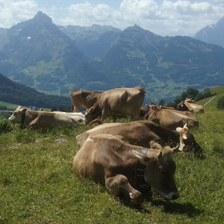

In [18]:
img = PIL.Image.open('img/cows.jpg').convert('RGB')
input = transform(img)
inv_transform(input)

### Run the model

In [19]:
def predict(input):
    """Run the model on an input and print the predicted classes with probabilities."""
    with torch.no_grad():
        [logits] = model(input[None])
        probs = torch.softmax(logits, dim=0)
        topk_prob, topk_id = torch.topk(probs, 5)
        for i in range(topk_prob.size(0)):
            print(classes[topk_id[i]], topk_prob[i].item(), sep="\t")

In [20]:
predict(input)

alp	0.8102790713310242
ox	0.10143321752548218
valley	0.030255474150180817
oxcart	0.007219813298434019
water buffalo	0.005635111127048731


### Capture and plot the attention weights

For simplicity, let's first plot just the attention weights inside the 5th block. To do this, we run the model again, but this time, we use NoPdb to capture the local variables inside the `forward` method of the `model.blocks[4].attn` layer:

In [21]:
with nopdb.capture_call(model.blocks[4].attn.forward) as attn_call:
    predict(input)

alp	0.8102790713310242
ox	0.10143321752548218
valley	0.030255474150180817
oxcart	0.007219813298434019
water buffalo	0.005635111127048731


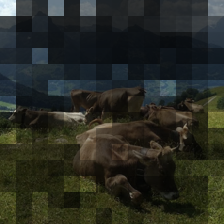

In [22]:
apply_mask(input, attn_call.locals["attn"][0][0].mean(axis=0)[1:])

<hr>

This project was supported by the [LabEx NUMEV](https://numev.edu.umontpellier.fr/) (ANR-10-LABX-0020) within the I-Site MUSE (ANR-16-IDEX-0006) and by the European Union's Horizon 2020 research and innovation programme under the Marie Skłodowska-Curie grant agreement No. 765068 ([MIP-Frontiers](https://mip-frontiers.eu/)).